### <p style="text-align: right;"> &#9989; Andrew Koren</p>

# PHY480 Day 23

## In-class assignment: Molecular dynamics simulations

In this in-class assignment we incorporate forces in the molecular dynamics simulations as well as modify the initialization functions.


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
%matplotlib inline

from scipy.spatial.distance import cdist
from random import sample


**Task 1.** Implement computation of forces for Lennard-Jones potential (set to zero for $r>r_{cut}$). Compute them also by hand for the three particles given below with periodic boundary conditions and check that your code produces the same result. Take into account that some particles are closer through the boundary.


In [57]:
### main parameters

# dimension
dim = 2

# number of particles
N = 3

# particle radius (for later plotting)
radius = 0.5

# set potential to zero at this distance
rcut = 2.5

# box sizes (the size of this array should match "dim"),
# to simplify, box size should be >= 2*rcut
lbox = np.array( [5.0,5.0] )

# allocate position array
r = np.zeros( (N,dim) )

# allocate array for the forces
f = np.zeros( (N,dim) )

# set fixed positions
r[0,0], r[0,1] = 0.5, 2
r[1,0], r[1,1] = 4, 1
r[2,0], r[2,1] = 2, 3.5


In [58]:
# compute force on every particle due to all other particles,
# Lennard-Jones potential 4(1/r^12-1/r^6)
# Input:
# lbox -- array with sizes
# r -- allocated array of shape N * dim,
#      where N is the number of particles and dim is the dimensionality
# f -- array for forces, same shape as r
# rcut -- maximum distance for the Lennard-Jones potential (set to 0 beyond)
# PBC -- =True if periodic boundary conditions are used, =False for hardwall boundary conditions
# Output:
# the input array f is changed
@njit
def forces_lj( lbox, r, f, rcut, PBC ):

    # set the parameters for calculation
    N = r.shape[0]  # read off the number of particles
    nd = r.shape[1] # read off the dimensions
    rcut_sq = rcut*rcut # to speed up comparisons #whats this for?
    dr = np.zeros(nd) # vector between two particles
    df = np.zeros(nd) # force contribution from one pair
    lbox2 = lbox/2 # speed up calculations
    
    # set the force array to zero
    f *= 0
    
    # loop over the first particle
    for i in range(N):
        # loop over the second particle
        for j in range(i+1, N):
            Dx = r[j] - r[i]
            if PBC:
                Dx = (Dx + lbox2) % lbox - lbox2

            # if dist_sq is less than rcut_sq, there is a contribution to the force from this pair
            dist = np.sqrt(np.sum(Dx**2))
            if dist < rcut:
                continue
            
            df = 24/dist**8 * ( 1 - 2/dist) * Dx
            f[i] += df
            f[j] -= df


**Task 2.** Implement computation of the potential energy, i.e. summing up the Lennard-Jones potential for all pairs within $r_{cut}$. Compute it also by hand for the same three-particle arrangement with periodic boundary conditions and check that your code produces the same result.

In [59]:
# compute potential energy for particles interacting with
# Lennard-Jones potential 4(1/r^12-1/r^6)
# Input:
# lbox -- array with sizes
# r -- allocated array of shape N * dim,
#      where N is the number of particles and dim is the dimensionality
# PBC -- =True if periodic boundary conditions are used, =False for hardwall boundary conditions
# Output:
# potential energy
@njit
def measure_pot( lbox, r, rcut, PBC=True ):
    
    # read off parameters
    N = r.shape[0]
    nd = r.shape[1]
    rcut_sq = rcut*rcut
    dr = np.zeros(nd)
    lbox2 = lbox/2

    pot = 0
    
    # loop over the first particle
    for i in range(N):
        # loop over the second particle
        for j in range(i+1, N):
            Dx = r[j] - r[i]
            if PBC:
                Dx = (Dx + lbox2) % lbox - lbox2
            
            dist = np.sqrt(np.sum(Dx**2))
            if dist < rcut:
                continue    

            pot += 4 * (dist**(-12) - dist**(-6))


    return pot


**Task 3.** Implement computation of the kinetic energy, i.e. summing $m_iv_i^2/2$ for all particles.


In [60]:
# compute the kinetic energy -- sum of mv^2/2 for all particles
# Input:
# v -- velocities, N*dim array
# masses -- arrya of size N with particle masses
def measure_kin( v, masses ):

    v2 = np.sum(v**2)
    return sum(v2*masses/2)


**Task 4.** Modify the function that generates random particle positions (we already built one in the previous in-class assignment) in the following way:

- loop over particles ($N$ in total),
- generate a random particle position,
- loop over the particles that you have already generated and check if the new particle is at distance $r\geqslant1$ away from every other particle,
- if that is not the case, discard and regenerate a new random position for that particle,
- repeat the process until an acceptable random position is found,
- add this particle position to the `r` array and proceed with the next particle.

This method will insure that the initial particle configuration cannot produce instabilities (i.e. large forces).


In [ ]:
# initialize particle positions
# Input:
# lbox -- array with sizes
# r -- allocated array of shape N * dim,
#      where N is the number of particles and dim is the dimensionality
# Output:
# the input r is changed
def initial_r( lbox, r ):
    N, dim = r.shape
    r[:] = np.random.rand(*r.shape) * lbox
    i = 1
    breaker = 0  

    while i < N:
        while (cdist(r[:N+1],r[:N+1]) + np.eye(len(r[:N+1]), len(r[:N+1]))*2 < 1).any():
            r[i] = np.random.rand(2) * lbox
            breaker += 1
            if breaker == 1000:
                r[:] = np.random.rand(*r.shape) * lbox
                breaker = 0
                i = 1
        breaker = 0
        i += 1
    
def easy_initial_r( lbox, r, jitter=0):
    grid_spacing = 1+jitter
    print(grid_spacing)
    grids = np.meshgrid(*[np.arange(1, l, grid_spacing) for l in lbox])
    print(grids)
    all_points = np.column_stack([grid.ravel() for grid in grids])

    apply_jitter = lambda x: x + (np.random.rand()-0.5)*jitter
    all_points = np.vectorize(apply_jitter)(all_points)

    assert (cdist(all_points, all_points) + 2*np.eye(len(all_points)) >= 1).all()
    r[:] = np.array(sample(list(all_points), k=len(r)))

**Task 5.** Modify the function that generates the initial velocities. The components of the velocity for each particle $i$ should be drawn from a Gaussian distribution with zero mean and $\sqrt{T/m_i}$ standard deviation, where $T$ is the temperature and $m_i$ is the $i$-th particle mass. Once all the velocities are generated, compute the velocity of the center of mass (i.e. compute the total momentum and divide by the total mass). Then subtract the center-of-mass velocity from the velocity of every particle.

In [ ]:
# initialize particle velocities, subtract the velocity of the center of mass
# Input:
# lbox -- array with sizes
# v -- allocated array of shape N * dim,
#      where N is the number of particles and dim is the dimensionality
# Output:
# the input v is changed
def initial_v( lbox, v, T, masses ):
    masses = np.array([[m] for m in masses])
    sigma = np.sqrt(T/masses)

    v[:] = np.random.randn(*v.shape)  * sigma
    
    total_momentum = np.sum(masses * v, axis=1, keepdims=True)
    total_mass = np.sum(masses)
    
    v[:] -= total_momentum / total_mass

<div style="page-break-after: always"></div>

**Task 7.** Modify the update functions for the position and velocity to incorporate the forces.


In [63]:
# propagate the particle positions by step dt
# Input:
# dt -- time step
# r -- array with particle positions
# v -- array with particle velocities
# Output:
# the input r is changed
def update_r( dt, r, v ):

    r[:] = r + v*dt

In [64]:
# propagate the particle velocities by step dt
# Input:
# dt -- time step
# v -- array with particle velocities
# f -- array with forces
# masses -- array with masses
# Output:
# the input v is changed
def update_v( dt, v, f, masses ):

    v[:] = v + f/np.array([[m] for m in masses])*dt

In [65]:
def boundary_periodic( lbox, r, v ):

    r[:] = r % lbox

def boundary_wall( lbox, r, v ):

    # loop on particles and r components,
    # if r is outside, reflect back in,
    # reverse the velocity if needed
    
    #safety
    if (abs(r - lbox/2) > lbox*1.5).any():
        raise ValueError('full ring not implemented!')

    #hard wall
    v[r<0] *= -1
    r[r<0] *= -1

    v[r>lbox] *= -1
    r[:] = np.where(r>lbox, 2*lbox-r, r)

boundary = [boundary_wall, boundary_periodic]

def temp_wall( lbox, r, v,):
    # walls drain energy

    #safety
    if (abs(r - lbox/2) > lbox*1.5).any():
        raise ValueError('full ring not implemented!')


    #hard wall
    v[r<0] *= -0.9
    r[r<0] *= -1

    v[r>lbox] *= -1
    r[:] = np.where(r>lbox, 2*lbox-r, r)



**Task 8.** Using the boundary conitions function from the previous assignment, put together a full molecular dynamics simulation. In the outer `Nsim` loop of the simulation measure the kinetic, potential and total energy in the simulation. Plot the total energy.


In [ ]:
### main parameters

dim = 2
N = 300 # increase once the code is working properly
radius = (2)**(1/6)/4
rcut = 3

# box sizes (the size of this array should match "dim"),
# to simplify, box size should be >= 2*rcut
lbox = np.array( [20.0,20.0] )

# allocate arrays for the position r and velocity v,
# the first index is particle index and the second is the vector component
r = np.zeros( (N,dim) )
v = np.zeros( (N,dim) )
f = np.zeros( (N,dim) )


masses = np.full( N, 1 )


# for reproducibility
np.random.seed(2)

# temperature (in microcanonical distribution it is only used for the initial configuration)
Temp = 1.3


NameError: name 'np' is not defined

In [67]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


#initial_r( lbox, r )
#easy_initial_r(lbox, r)
#initial_v( lbox, v, Temp, masses )

## sim parameters
PBC = False
runtime = 10 # seconds
fps = 30

dt = 1/fps
Nsim = int(runtime*fps)

Ninner = 1 # do not change!
capture_period = 1

print(dt, 's per frame')
print(Nsim, 'frames')

speedup = 1

0.03333333333333333 s per frame
300 frames


In [68]:
r_storage = np.zeros([Nsim,*r.shape])
kin_storage = []
pot_storage = []

easy_initial_r( lbox, r )
initial_v( lbox, v, Temp, masses)

print('initialization successful!')

# run sim
for i in range(Nsim):
    r_storage[i] = r
    update_r( dt, r, v)
    boundary[PBC](lbox, r, v )

# main simulation loop
for i in range(Nsim):
    # inner loop
    for j in range(Ninner):
        # propagate velocities by dt/2
        update_v(dt/2, v, f, masses)
        # propagate positions r by dt
        update_r(dt, r, v)
        # app
        # ly boundary conditions
        #boundary[PBC]( lbox, r, v )
        temp_wall( lbox, r, v )
        # compute forces
        forces_lj( lbox, r, f, rcut, PBC)
        # propagate velocities by dt/2
        update_v(dt/2, v, f, masses)
    r_storage[i] = r

    kin_storage.append(measure_kin(v, masses))
    pot_storage.append(measure_pot(lbox, r, rcut, PBC)) #slow

total_energy = np.array(kin_storage) + np.array(pot_storage)
temperature = 2 * np.array(kin_storage) / (dim * N)



initialization successful!


In [ ]:
## animate

fig, ax = plt.subplots(figsize=(6,6))

plt.xlim(0-radius, lbox[0]+radius)
plt.ylim(0-radius, lbox[1]+radius)

# scale point size while using ax.scatter
data_to_pixels = ax.transData.transform
p0 = data_to_pixels((0, 0))      # Origin in pixels
p1 = data_to_pixels((radius, 0))      # Point at (r, 0) in pixels
pixel_r = p1[0] - p0[0]          # Pixel distance for `r`
points_per_pixel = 72 / fig.dpi   # Standard typographic conversion
diameter_points = 2 * pixel_r * points_per_pixel
s = diameter_points ** 2

#initialize plot
particles = ax.scatter(r_storage[0, :,0], r_storage[0, :,1], s=s) 

def update(frame):
    particles.set_offsets(frame)
    return particles,

#see code below
#ani = FuncAnimation(fig, update, frames=r_storage[::capture_period], blit=True, interval=dt*1000*capture_period)
#plt.close(fig) ## needed to stop another static image from being displayed
#
## Display the animation in the notebook
#HTML(ani.to_jshtml())
## Saving
#ani.save('dynamics.webp')

KeyboardInterrupt: 

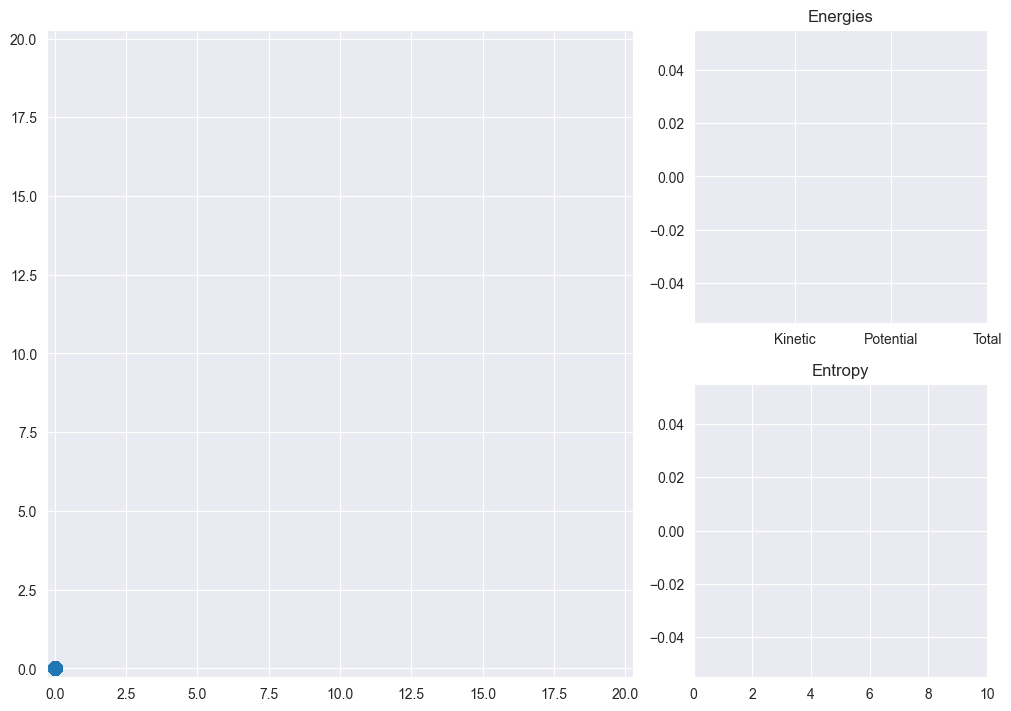

In [ ]:
# import matplotlib.pyplot as plt


# fig = plt.figure(constrained_layout=True)
# axs = fig.subplot_mosaic([['Left', 'TopRight'],['Left', 'BottomRight']],
#                           gridspec_kw={'width_ratios':[2, 1]})

# fig.set_figwidth(10)
# fig.set_figheight(7)

# main_ax = axs['Left']
# axs['TopRight'].set_title('Energies')
# axs['BottomRight'].set_title('Entropy')

# main_ax.set_xlim(0-radius, lbox[0]+radius)
# main_ax.set_ylim(0-radius, lbox[1]+radius)

# # draw point radius accurately with ax.scatter
# data_to_pixels = main_ax.transData.transform
# p0 = data_to_pixels((0, 0))      # Origin in pixels
# p1 = data_to_pixels((radius, 0))      # Point at (r, 0) in pixels
# pixel_r = p1[0] - p0[0]          # Pixel distance for `r`
# points_per_pixel = 72 / fig.dpi   # Standard typographic conversion
# diameter_points = 2 * pixel_r * points_per_pixel
# s = diameter_points ** 2

# # initialize curves
# particles = main_ax.scatter(r_storage[0, :,0], r_storage[0, :,1], s=s) #repeats first frame but whatever

# kinetic, = axs['TopRight'].plot(time[0], kin_storage[0], color='blue', label='Kinetic Energy')
# potential, = axs['TopRight'].plot(time[0], pot_storage[0], color='red', label='Potential Energy')
# total, = axs['TopRight'].plot(time[0], kin_storage[0] + pot_storage[0], color='green', label='Total Energy')
# axs['TopRight'].set_xticks([1, 2, 3])
# axs['TopRight'].set_xticklabels(['Kinetic', 'Potential', 'Total'])


# entropy_plot = axs['BottomRight'].plot(time[0], sigma[1])
# axs['BottomRight'].set_xlim(0, runtime)

# # animation
# def update(input_frame):
#     i, r = input_frame
#     particles.set_offsets(r)
#     kinetic.set_data(time[:i], kin_storage[:i])
#     potential.set_data(time[:i], kin_storage[:i])
#     total.set_data(time[:], kin_storage[:i])

#     return [particles, kinetic, potential, total]

# #ani = FuncAnimation(fig, update, frames=[i for i in enumerate(r_storage[::capture_period])], blit=True, interval=dt*1000*capture_period, save_count=Nsim)
# #plt.close(fig) ## needed to stop another static image from being displayed
# #
# ## Display the animation in the notebook
# #HTML(ani.to_jshtml())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
import os
import base64


class ParticleAnimator:
    def __init__(self, fig, Writer, filename):
        self.fig = fig
        self.Writer = Writer
        self.filename = filename
        # List of animation tasks.
        self.animation_sequence = []
        # Optionally hold registered artists (if needed across tasks).
        self.artists = {}

    def register_artist(self, name, artist): #optional
        self.artists[name] = artist

    def set_display(self, fps, total_time):
        """Set up simulation display parameters."""
        self.fps = fps
        self.T = total_time
        self.dt = 1 / fps
        self.frames = int(total_time * fps)

    def generate_frame_data(self, data, update_period=None, update_fps=None):
        """
        Given a list 'data' (each element holding frame input) and an update condition,
        this function creates a dictionary mapping each simulation frame (0-indexed)
        to the last update value.
        """
        if update_fps is not None:
            update_interval = int(self.fps / update_fps)
        elif update_period is not None:
            update_interval = int(update_period / self.dt)
        else:
            update_interval = 1  # Update every frame

        # Create a dictionary of frame data. At frames that are multiples of update_interval,
        # we pick the next value from 'data' (if available). Otherwise, repeat the last value.
        frame_data = {}
        current_data = None
        update_index = 0
        for i in range(self.frames):
            if i % update_interval == 0 and update_index < len(data):
                current_data = data[update_index]
                update_index += 1
            frame_data[i] = current_data
        return frame_data

    def animate_ax(self, ax, method, frame_data, *args):
        """
        Register an animation task. 
        - ax: the axis to update.
        - method: update function that takes (ax, frame_data, *args)
        - frame_data: a dictionary mapping frame number to data.
        - args: additional fixed arguments (e.g., dynamic artist handles) to pass.
        """
        self.animation_sequence.append({
            'ax': ax,
            'method': method,
            'frame_data': frame_data,
            'args': args
        })

    def make_animation(self):
        """
        Loop over frames, calling each animation task's method if its update data exists,
        then capturing the frame with writer.grab_frame().
        """
        writer = self.Writer(self.fps)
        with writer.saving(self.fig, self.filename, dpi=100):
            for i in range(self.frames):
                for anim in self.animation_sequence:
                    frame_input = anim['frame_data'][i]
                    if frame_input is not None:
                        anim['method'](anim['ax'], frame_input, *anim['args'])
                writer.grab_frame()
    
    def display(self, width=800):
        """Auto-display an animation inline (MP4, GIF, or WebP) in a Jupyter notebook."""
        ext = os.path.splitext(self.filename)[1].lower()

        with open(self.filename, "rb") as file_:
            data = file_.read()
        encoded = base64.b64encode(data).decode("utf-8")

        # ffmpeg or pillow
        if ext == ".mp4":
            return HTML(f"""
            <video width="{width}" controls>
                <source src="data:video/mp4;base64,{encoded}" type="video/mp4">
                Your browser does not support the video tag.
            </video>
            """)
        elif ext == ".gif":
            return HTML(f"""
            <img src="data:image/gif;base64,{encoded}" width="{width}">
            """)
        elif ext == ".webp":
            return HTML(f"""
            <img src="data:image/webp;base64,{encoded}" width="{width}">
            """)
        else:
            return HTML("<p>Unsupported file format for inline display.</p>")




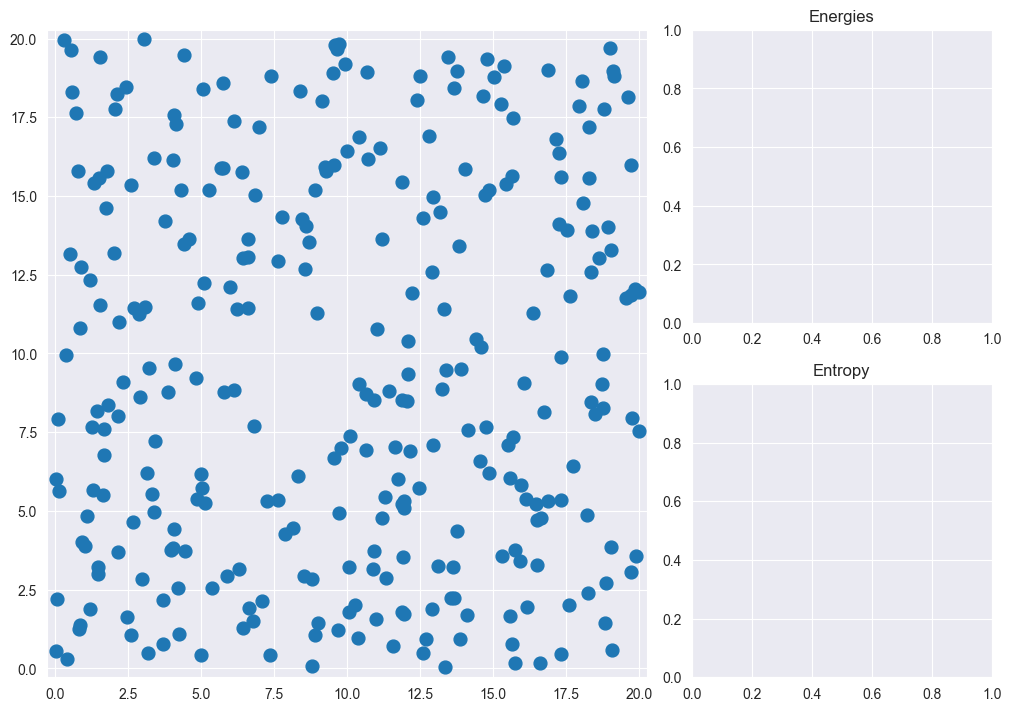

In [71]:
output_file = "molecular_dynamics_view.mp4"
fig = plt.figure(constrained_layout=True)
axs = fig.subplot_mosaic([['Left', 'TopRight'],['Left', 'BottomRight']],
                          gridspec_kw={'width_ratios':[2, 1]})

fig.set_figwidth(10)
fig.set_figheight(7)

main_ax = axs['Left']
axs['TopRight'].set_title('Energies')
axs['BottomRight'].set_title('Entropy')

main_ax.set_xlim(0-radius, lbox[0]+radius)
main_ax.set_ylim(0-radius, lbox[1]+radius)

# draw point radius accurately with ax.scatter
data_to_pixels = main_ax.transData.transform
p0 = data_to_pixels((0, 0))      # Origin in pixels
p1 = data_to_pixels((radius, 0))      # Point at (r, 0) in pixels
pixel_r = p1[0] - p0[0]          # Pixel distance for `r`
points_per_pixel = 72 / fig.dpi   # Standard typographic conversion
diameter_points = 2 * pixel_r * points_per_pixel
s = diameter_points ** 2

energy_min, energy_max = min(
min(kin_storage)-kin_storage[0], min(pot_storage)-pot_storage[0], min(kin_storage)+min(pot_storage)-kin_storage[0]-pot_storage[0]), \
max(max(kin_storage)-kin_storage[0], max(pot_storage)-pot_storage[0], max(kin_storage)+max(pot_storage)-kin_storage[0]-pot_storage[0]
)

particles = main_ax.scatter(r_storage[0,:,0], r_storage[0,:,1], s=s)
def draw_particles(ax, frame_data):
    particles.set_offsets(frame_data)
    


animator = ParticleAnimator( fig, FFMpegWriter, output_file )
animator.set_display(fps, runtime)
particle_frames = animator.generate_frame_data(r_storage)
animator.animate_ax(main_ax, draw_particles, particle_frames)

In [72]:
animator.make_animation()
animator.display()

&#169; Copyright 2025,  Michigan State University Board of Trustees